In [ ]:
!pip install -q fbprophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [ ]:
df = pd.read_excel('/content/btc_eth_ltc.xlsx', index_col=1)

In [ ]:
df = df.sort_values('Date')
df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,ETHUSD,202.67,207.89,202.50,205.86,21165.529375
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-16 04:00:00,1539662400000,BTCUSD,6423.27,6489.99,6390.10,6444.08,2978.589591
2018-10-17 04:00:00,1539748800000,BTCUSD,6444.08,6487.77,6406.98,6459.26,1998.462064
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
...,...,...,...,...,...,...,...
2021-09-21 04:00:00,1632196800000,ETHUSD,2998.29,3104.42,2650.85,2869.31,46289.916678
2021-09-21 04:00:00,1632196800000,LTCUSD,159.47,162.20,144.62,151.48,46606.739750
2021-09-22 04:00:00,1632283200000,BTCUSD,42089.88,44047.48,41836.59,43559.58,1051.581492


In [ ]:
df['Symbol'].unique()

array(['ETHUSD', 'LTCUSD', 'BTCUSD'], dtype=object)

In [ ]:
df.groupby('Symbol')['Unix Timestamp'].nunique()

Symbol
BTCUSD    1073
ETHUSD    1073
LTCUSD    1073
Name: Unix Timestamp, dtype: int64

<BarContainer object of 3 artists>

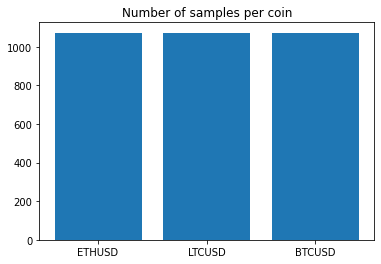

In [ ]:
plt.title('Number of samples per coin')
plt.bar(df['Symbol'].unique(),df.groupby('Symbol')['Unix Timestamp'].nunique())

In [ ]:
#Split dataframes
list_df = {}
for name in df['Symbol'].unique():
    print(name)
    list_df.update({name:df[df.Symbol==name]})

ETHUSD
LTCUSD
BTCUSD


In [ ]:
ltc_df = list_df.get('LTCUSD')
btc_df = list_df.get('BTCUSD')
eth_df = list_df.get('ETHUSD')


In [ ]:
ltc_df

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2018-10-16 04:00:00,1539662400000,LTCUSD,0.00,55.20,0.00,52.92,5601.926989
2018-10-17 04:00:00,1539748800000,LTCUSD,52.92,54.50,52.43,53.52,4206.391895
2018-10-18 04:00:00,1539835200000,LTCUSD,53.52,53.87,51.25,51.88,3150.270139
2018-10-19 04:00:00,1539921600000,LTCUSD,51.88,51.88,51.88,51.88,0.000000
2018-10-20 04:00:00,1540008000000,LTCUSD,51.88,52.75,51.88,52.75,1.000000
...,...,...,...,...,...,...,...
2021-09-18 04:00:00,1631937600000,LTCUSD,182.08,185.74,178.43,179.44,21093.113429
2021-09-19 04:00:00,1632024000000,LTCUSD,179.44,181.60,163.50,167.01,31279.361709
2021-09-20 04:00:00,1632110400000,LTCUSD,167.01,168.18,150.22,159.47,86803.808889


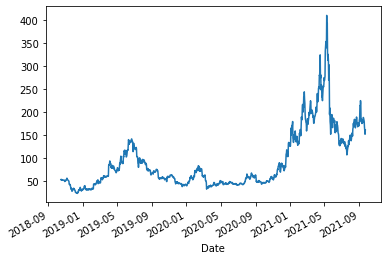

In [ ]:
ltc_df['Close'].plot()

In [ ]:
prophet_df=pd.DataFrame()
prophet_df['y'] = ltc_df['Close']
prophet_df['ds'] = ltc_df.index
prophet_df.reset_index(drop=True, inplace=True)

In [ ]:
prophet_df

,y,ds
0,52.92,2018-10-16 04:00:00
1,53.52,2018-10-17 04:00:00
2,51.88,2018-10-18 04:00:00
3,51.88,2018-10-19 04:00:00
4,52.75,2018-10-20 04:00:00
...,...,...
1068,179.44,2021-09-18 04:00:00
1069,167.01,2021-09-19 04:00:00
1070,159.47,2021-09-20 04:00:00
1071,151.48,2021-09-21 04:00:00


In [ ]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=None, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faaf7a76190>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fab01910790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fab01910790>
INFO:fbprophet:Disabling daily seasonality. Run p

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  66.666733
1                     0.001                     0.10  69.983707
2                     0.001                     1.00  70.213254
3                     0.001                    10.00  70.199259
4                     0.010                     0.01  57.746157
5                     0.010                     0.10  60.193736
6                     0.010                     1.00  60.422671
7                     0.010                    10.00  60.086691
8                     0.100                     0.01  46.898644
9                     0.100                     0.10  46.943445
10                    0.100                     1.00  47.306868
11                    0.100                    10.00  46.926092
12                    0.500                     0.01  41.791731
13                    0.500                     0.10  44.856619
14                    0.500             

In [ ]:
prophet = Prophet(changepoint_prior_scale = 0.500, seasonality_prior_scale= 0.01, seasonality_mode='multiplicative')
prophet.fit(prophet_df)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=7)
future.tail()

,ds
1075,2021-09-25 04:00:00
1076,2021-09-26 04:00:00
1077,2021-09-27 04:00:00
1078,2021-09-28 04:00:00
1079,2021-09-29 04:00:00


In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1073,2021-09-23 04:00:00,163.169958,146.403488,179.956682
1074,2021-09-24 04:00:00,164.445397,148.019044,180.537416
1075,2021-09-25 04:00:00,162.249490,146.365343,178.188845
1076,2021-09-26 04:00:00,161.428988,144.322024,177.523354
1077,2021-09-27 04:00:00,159.968521,144.101995,176.680474
1078,2021-09-28 04:00:00,160.601251,144.670448,178.129494
1079,2021-09-29 04:00:00,158.344300,140.685671,174.753285


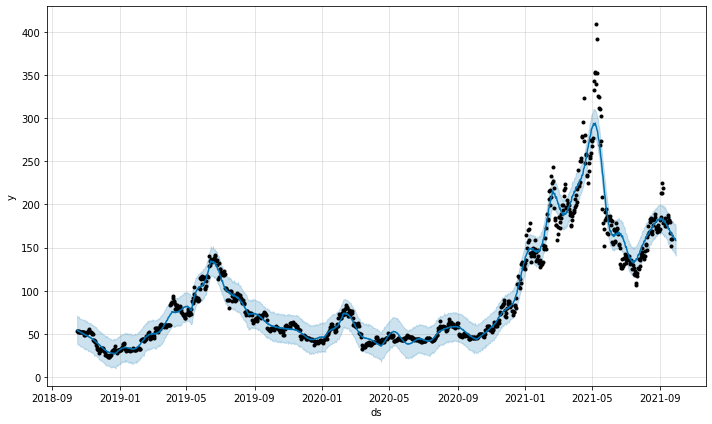

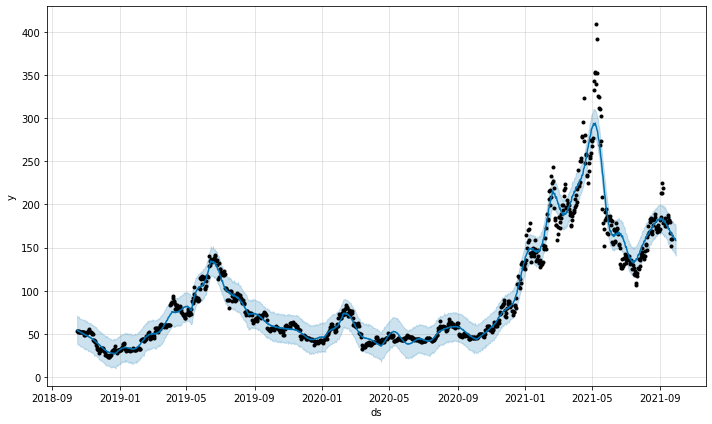

In [ ]:
prophet.plot(forecast)

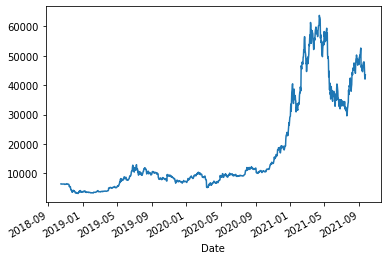

In [ ]:
btc_df['Close'].plot()

###BTC

In [ ]:
prophet_df=pd.DataFrame()
prophet_df['y'] = btc_df['Close']
prophet_df['ds'] = btc_df.index
prophet_df.reset_index(drop=True, inplace=True)

In [ ]:
prophet_df

,y,ds
0,6444.08,2018-10-16 04:00:00
1,6459.26,2018-10-17 04:00:00
2,6383.39,2018-10-18 04:00:00
3,6383.39,2018-10-19 04:00:00
4,6382.04,2018-10-20 04:00:00
...,...,...
1068,47854.23,2021-09-18 04:00:00
1069,45553.62,2021-09-19 04:00:00
1070,42688.03,2021-09-20 04:00:00
1071,42089.88,2021-09-21 04:00:00


In [ ]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=None, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faaf5ea1150>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fab1293a290>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faaf7afa090>
INFO:fbprophet:Disabling daily seasonality. Run p

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  14414.237359
1                     0.001                     0.10  14830.271474
2                     0.001                     1.00  14818.719813
3                     0.001                    10.00  14829.608787
4                     0.010                     0.01  10948.916642
5                     0.010                     0.10  11035.813865
6                     0.010                     1.00  10978.757076
7                     0.010                    10.00  10966.130785
8                     0.100                     0.01   7473.151985
9                     0.100                     0.10   6478.940839
10                    0.100                     1.00   6449.761024
11                    0.100                    10.00   6402.707439
12                    0.500                     0.01   6631.330905
13                    0.500                     0.10   5517.92

In [ ]:
prophet = Prophet(changepoint_prior_scale = 0.500, seasonality_prior_scale= 0.10, seasonality_mode='multiplicative')
prophet.fit(prophet_df)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=7)
future.tail()

,ds
1075,2021-09-25 04:00:00
1076,2021-09-26 04:00:00
1077,2021-09-27 04:00:00
1078,2021-09-28 04:00:00
1079,2021-09-29 04:00:00


In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1073,2021-09-23 04:00:00,43278.307564,41490.453784,45046.732104
1074,2021-09-24 04:00:00,43333.654171,41539.285338,45170.366117
1075,2021-09-25 04:00:00,42771.945029,40988.990198,44532.666464
1076,2021-09-26 04:00:00,42338.129366,40484.344670,44215.626255
1077,2021-09-27 04:00:00,41619.038221,39826.249410,43338.662295
1078,2021-09-28 04:00:00,41223.292002,39355.517668,42985.721210
1079,2021-09-29 04:00:00,41009.481931,39131.204563,42826.299893


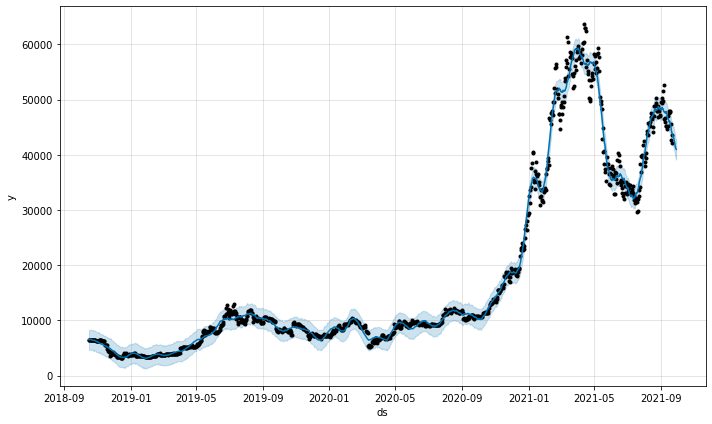

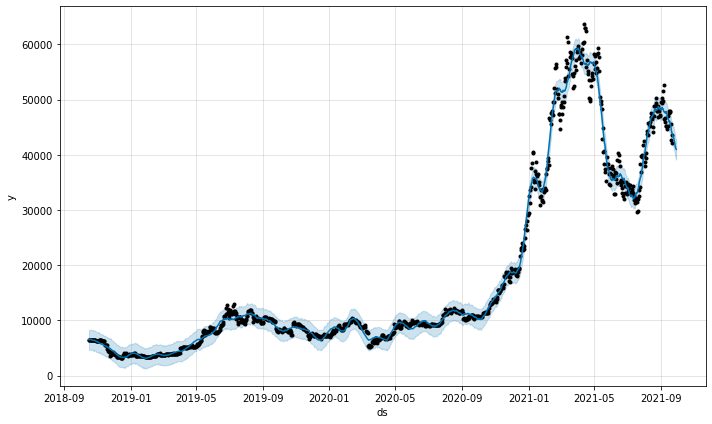

In [ ]:
prophet.plot(forecast)

###ETH

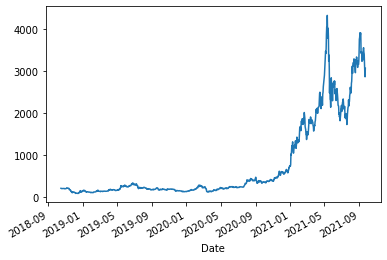

In [ ]:
eth_df['Close'].plot()

In [ ]:
prophet_df=pd.DataFrame()
prophet_df['y'] = eth_df['Close']
prophet_df['ds'] = eth_df.index
prophet_df.reset_index(drop=True, inplace=True)

In [ ]:
prophet_df

,y,ds
0,205.86,2018-10-16 04:00:00
1,204.60,2018-10-17 04:00:00
2,199.43,2018-10-18 04:00:00
3,199.43,2018-10-19 04:00:00
4,200.73,2018-10-20 04:00:00
...,...,...
1068,3413.18,2021-09-18 04:00:00
1069,3187.56,2021-09-19 04:00:00
1070,2998.29,2021-09-20 04:00:00
1071,2869.31,2021-09-21 04:00:00


In [ ]:
import itertools
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(prophet_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=None, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faaf7b03c10>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fab00632950>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-10-18 04:00:00 and 2021-08-23 04:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7faaf7b92dd0>
INFO:fbprophet:Disabling daily seasonality. Run p

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  889.070957
1                     0.001                     0.10  912.354806
2                     0.001                     1.00  914.548415
3                     0.001                    10.00  914.475037
4                     0.010                     0.01  425.340101
5                     0.010                     0.10  424.094287
6                     0.010                     1.00  421.806951
7                     0.010                    10.00  423.696319
8                     0.100                     0.01  413.364222
9                     0.100                     0.10  431.780231
10                    0.100                     1.00  428.313877
11                    0.100                    10.00  432.444307
12                    0.500                     0.01  378.479868
13                    0.500                     0.10  409.739860
14                    0.5

In [ ]:
prophet = Prophet(changepoint_prior_scale = 0.500, seasonality_prior_scale= 0.01, seasonality_mode='multiplicative')
prophet.fit(prophet_df)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=7)
future.tail()

,ds
1075,2021-09-25 04:00:00
1076,2021-09-26 04:00:00
1077,2021-09-27 04:00:00
1078,2021-09-28 04:00:00
1079,2021-09-29 04:00:00


In [ ]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1073,2021-09-23 04:00:00,3192.629741,3036.047766,3343.253325
1074,2021-09-24 04:00:00,3173.262228,3004.025568,3320.123003
1075,2021-09-25 04:00:00,3144.953601,2999.249376,3296.678974
1076,2021-09-26 04:00:00,3119.352698,2981.178390,3255.033920
1077,2021-09-27 04:00:00,3103.992709,2959.192540,3235.171816
1078,2021-09-28 04:00:00,3094.455872,2942.968188,3240.920225
1079,2021-09-29 04:00:00,3105.230771,2961.746961,3247.145537


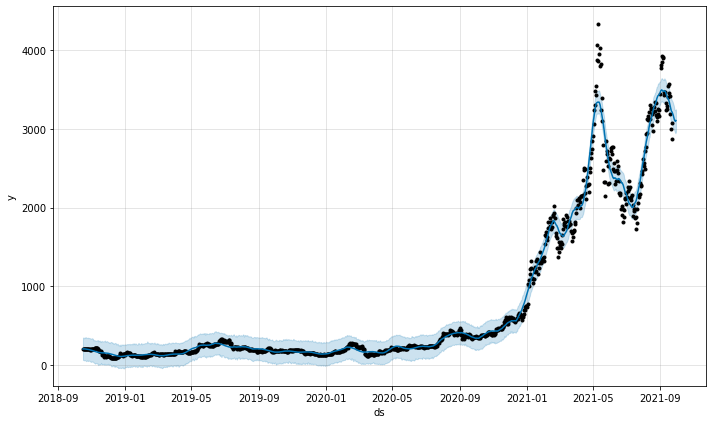

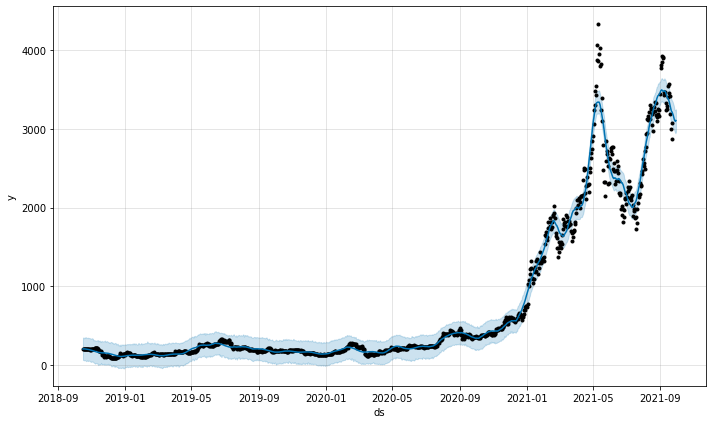

In [ ]:
prophet.plot(forecast)